# ECG Feature Extraction

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import pendulum
import statistics
import json

from scipy.signal import argrelextrema
from biosppy.signals import ecg

In [3]:
%%capture
# Notebook settings

# Display plots
%pylab inline

# Set seaborn plot parameters
sns.set(
    rc={
        'figure.figsize':(15, 5) # length and height in inches (assuming 100 dpi)
    }
)

In [4]:
# Parameters
SAMPLING_RATE_HZ = 1000
REACTION_TIME_MS = 250

ROOT_DATA_FOLDER = "data"
DEVICE = "BITalino"
ECG_FILENAME = "BPM_p.csv"
TIMEZONE = "Europe/Warsaw"

Data samples represent ECG measurements made on experiment participant.

They are stored in files containing two columns: timestamp and measured heart electrical activity in millivolts. Sampling rate is 1000Hz.

In [5]:
# Load first data sample
participant_id = "B303"
data_dir = os.path.join(ROOT_DATA_FOLDER, participant_id)
data_path = os.path.join(data_dir, DEVICE, ECG_FILENAME)
data = pd.read_csv(data_path, sep=', ', engine="python")

Each data sample has additional metadata associated with it, consisting of timestamps and events - for example images presented to test subject during measurements. 

Metadata example:

In [6]:
def extract_features(signal):
    r_positions = ecg.engzee_segmenter(signal.value.values, SAMPLING_RATE_HZ)[0]
    rr_intervals = r_positions[1:] - r_positions[:-1]
    rr_mean = np.mean(rr_intervals)
    diffs = rr_intervals[1:] - rr_intervals[:-1]
    return {
        "mad": np.median(np.abs(rr_intervals - rr_mean)),
        "sdnn": np.std(rr_intervals),
        "rmssd": np.sqrt(np.mean(diffs ** 2)),
        "sdsd": np.std(diffs),
        "pnn20": len(diffs[abs(diffs) > 20]) / len(diffs),
        "pnn50": len(diffs[abs(diffs) > 50]) / len(diffs),
    }

In [12]:
metadata_path = glob.glob(f"{data_dir}/*testEx*")[0]
metadata = pd.read_csv(metadata_path, header=None, names=["event", "timestamp"])
metadata.timestamp = metadata.timestamp.apply(lambda x: int(pendulum.parse(x, tz=TIMEZONE).timestamp() * 1000))
last_timestamp = data.timestamp.values[-1]
if metadata.timestamp.values[-1] < last_timestamp:
    end_event = {"event": "end", "timestamp": last_timestamp}
    metadata = metadata.append(end_event, ignore_index=True)
windows = pd.DataFrame(
    {
        "event": metadata.event.values[:-1],
        "windowStart": metadata.timestamp.values[:-1] + REACTION_TIME_MS,
        "windowEnd": metadata.timestamp.values[1:] + REACTION_TIME_MS,
    }
)
segmented_data = windows.apply(lambda x: data[data.timestamp.between(x.windowStart, x.windowEnd)], axis='columns')
features = pd.DataFrame([extract_features(segment) for segment in segmented_data])
result = pd.concat([windows, features], axis='columns')
result

event    windowStart      windowEnd  \
0                 pictures\trail\3.jpg  1520845866644  1520845877571   
1                 pictures\trail\1.jpg  1520845877571  1520845888552   
2                 pictures\trail\6.jpg  1520845888552  1520845899566   
3                 pictures\trail\4.jpg  1520845899566  1520845910706   
4                 pictures\trail\2.jpg  1520845910706  1520845921566   
5                 pictures\trail\5.jpg  1520845921566  1520846027941   
6   pictures\day1\Landscapes_097_v.jpg  1520846027941  1520846038944   
7   pictures\day1\Landscapes_049_h.jpg  1520846038944  1520846049953   
8      pictures\day1\Objects_160_h.jpg  1520846049953  1520846060912   
9      pictures\day1\Animals_056_h.jpg  1520846060912  1520846071923   
10      pictures\day1\People_038_h.jpg  1520846071923  1520846082933   
11      pictures\day1\People_130_h.jpg  1520846082933  1520846093929   
12  pictures\day1\Landscapes_050_h.jpg  1520846093929  1520846104926   
13  pictures\day1\Landscapes_104_h.jpg  1520846104926  1520846115922   
14     pictures\day1\Animals_020_h.jpg  1520846115922  1520846126933   
15  pictures\day1\Landscapes_067_h.jpg  1520846126933  1520846137933   
16  pictures\day1\Landscapes_103_v.jpg  1520846137933  1520846148926   
17      pictures\day1\People_208_h.jpg  1520846148926  1520846159939   
18       pictures\day1\Faces_159_h.jpg  1520846159939  1520846170941   
19     pictures\day1\Animals_090_h.jpg  1520846170941  1520846181931   
20       pictures\day1\Faces_134_h.jpg  1520846181931  1520846192918   
21       pictures\day1\Faces_234_h.jpg  1520846192918  1520846203934   
22  pictures\day1\Landscapes_054_h.jpg  1520846203934  1520846214935   
23     pictures\day1\Animals_035_h.jpg  1520846214935  1520846255947   
24     pictures\day1\Objects_014_h.jpg  1520846255947  1520846266934   
25      pictures\day1\People_028_h.jpg  1520846266934  1520846277940   
26  pictures\day1\Landscapes_120_v.jpg  1520846277940  1520846288942   
27       pictures\day1\Faces_149_v.jpg  1520846288942  1520846299939   
28      pictures\day1\People_198_h.jpg  1520846299939  1520846310951   
29      pictures\day1\People_211_v.jpg  1520846310951  1520846321941   
30     pictures\day1\Objects_046_h.jpg  1520846321941  1520846332946   
31       pictures\day1\Faces_008_h.jpg  1520846332946  1520846343937   
32     pictures\day1\Objects_186_v.jpg  1520846343937  1520846354946   
33  pictures\day1\Landscapes_123_h.jpg  1520846354946  1520846365918   
34     pictures\day1\Objects_001_h.jpg  1520846365918  1520846376930   
35     pictures\day1\Objects_146_h.jpg  1520846376930  1520846387927   
36      pictures\day1\People_110_h.jpg  1520846387927  1520846398927   
37      pictures\day1\People_201_v.jpg  1520846398927  1520846409929   
38      pictures\day1\People_127_h.jpg  1520846409929  1520846420933   
39  pictures\day1\Landscapes_061_h.jpg  1520846420933  1520846431930   
40       pictures\day1\Faces_202_v.jpg  1520846431930  1520846442934   
41     pictures\day1\Objects_132_h.jpg  1520846442934  1520846461778   

          mad     pnn20     pnn50      rmssd       sdnn       sdsd  
0   47.533333  0.285714  0.071429  27.281600  50.908895  27.116152  
1   22.000000  0.384615  0.076923  29.897260  39.467437  29.897260  
2   16.533333  0.285714  0.000000  18.782591  20.969396  18.759623  
3   34.533333  0.428571  0.071429  27.683156  38.885930  27.678641  
4   36.357143  0.384615  0.000000  23.910088  37.313072  23.908108  
5   46.000000  0.341935  0.070968  26.670994  62.863620  26.665488  
6   37.666667  0.500000  0.000000  23.864199  47.239343  23.717405  
7    8.933333  0.214286  0.000000  13.242248  12.709402  13.232806  
8    8.333333  0.142857  0.000000  11.423660  14.763318  11.418076  
9   21.000000  0.307692  0.000000  16.986420  28.136421  16.280456  
10  49.133333  0.428571  0.000000  21.993506  44.416013  21.513166  
11  17.500000  0.461538  0.000000  22.680049  21.585260  22.679918  
12  11.400000  0.214286  0.000000  19.1

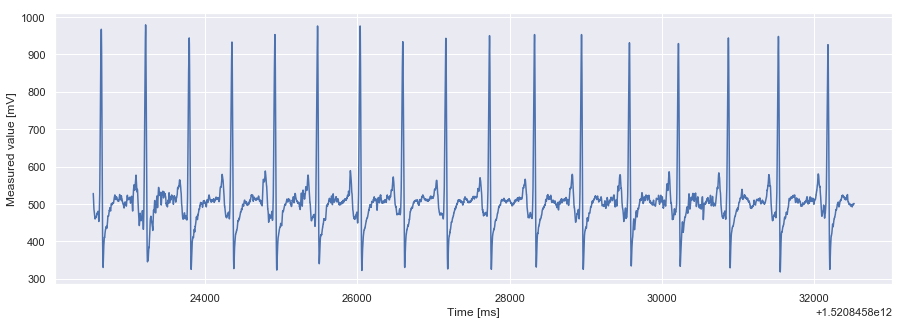

In [7]:
sample = data.head(10000)
ax = sns.lineplot(x="timestamp", y="value", data=sample)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Measured value [mV]");

In [14]:
# Calculate R spikes position using biosppy.signals.ecg
r_timestamps = ecg.engzee_segmenter(sample.value.values, SAMPLING_RATE_HZ)[0]
spikes = data.iloc[r_timestamps]

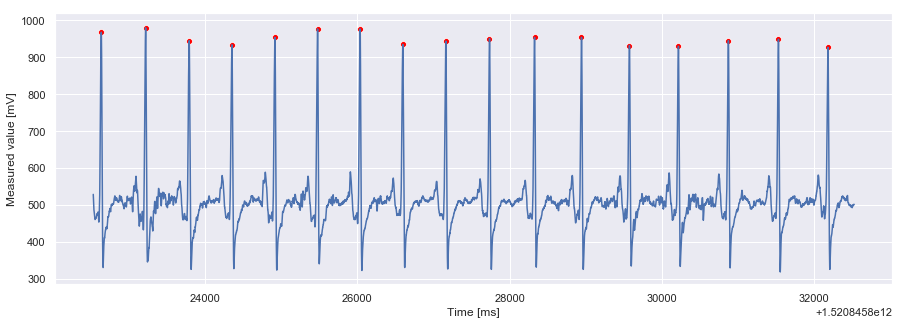

In [9]:
# Plot detected R spikes
ax = sns.lineplot(x="timestamp", y="value", data=sample)
sns.scatterplot(x="timestamp", y="value", data=spikes, color="red")

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Measured value [mV]");

## ECG features
- Median of absolute deviation (MAD) from mean RR interval
- Standard deviation of NN intervals (SDNN)
- Root Mean Square of Successive Differences (RMSSD). This is RMS of differences between successive, neighbouring RR intervals
- Standard Deviation of Successive Differences (SDSD) [standard deviation of the above]
- Ratio of differences between successive intervals greater than 20ms (pNN20) and 50ms (pNN50).

In [10]:
r_timestamps = ecg.engzee_segmenter(data.value.values, SAMPLING_RATE_HZ)[0]
rr_intervals = r_timestamps[1:] - r_timestamps[:-1]
rr_mean = np.mean(rr_intervals)
diffs = rr_intervals[1:] - rr_intervals[:-1]

mad = np.median(np.abs(rr_intervals - rr_mean))
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(diffs ** 2))
sdsd = np.std(diffs)
pnn20 = len(diffs[abs(diffs) > 20]) / len(diffs)
pnn50 = len(diffs[abs(diffs) > 50]) / len(diffs)

Box output shall be set of 6 basic features for each window, serialized as Parquet. JSON preview for single window is below:

In [11]:
print(json.dumps({
    "mad": mad,
    "sdnn": sdnn,
    "rmssd": rmssd,
    "sdsd": sdsd,
    "pnn20": pnn20,
    "pnn50": pnn50
}, indent=2))

{
  "mad": 32.584615384615404,
  "sdnn": 51.6434201059214,
  "rmssd": 22.486030377908317,
  "sdsd": 22.48565566635988,
  "pnn20": 0.3333333333333333,
  "pnn50": 0.027502750275027504
}
